#### CNN 이미지 분류 모델
- 이미지 데이터셋 준비
    * torchvision의 내장 데이터셋 활용 CIFAR 10
- 이미지 분류 모델
    * 커스텀 CNN 구현

[1] 모듈 로딩 및 데이터 준비 <hr>

In [43]:
### 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision.datasets import CIFAR10        # torchvision 내장 데이터셋 관련 모듈
from torchvision.transforms import ToTensor     # torchvision 데이터 변환 관련 모듈
from torch.utils.data import DataLoader         # 데이터셋 관련 모듈
import matplotlib.pyplot as plt

In [37]:
## 데이터 로딩
DIR_PATH = '../data/'
## Pytorch의 Dataset 형태 로딩
cifarDS=CIFAR10(DIR_PATH,
                train=True,
                download=True,
                transform=ToTensor())

Files already downloaded and verified


In [38]:
type(cifarDS)

torchvision.datasets.cifar.CIFAR10

In [39]:
# Dataset의 속성 확인
print(f'cifarDS.classes: {cifarDS.classes}')

print(f'cifarDS.class_to_idx: {cifarDS.class_to_idx}')

print(f'cifarDS.data.shape: {cifarDS.data.shape}')

print(f'len(cifarDS.targets): {len(cifarDS.targets)}')

# len(cifarDS.targets)
# cifarDS.targets

cifarDS.classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarDS.class_to_idx: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
cifarDS.data.shape: (50000, 32, 32, 3)
len(cifarDS.targets): 50000


[2] 데이터 로더 <hr>
- 학습 시 배치크기만큼 데이터와 라벨/타겟을 로딩

In [40]:
BATCH_SIZE = 50

cifar10DL = DataLoader(cifarDS)

tensor([6])
data: torch.Size([1, 3, 32, 32])
data1: torch.Size([3, 32, 32])
imshow(data1.transpose(0,2)): torch.Size([32, 32, 3])


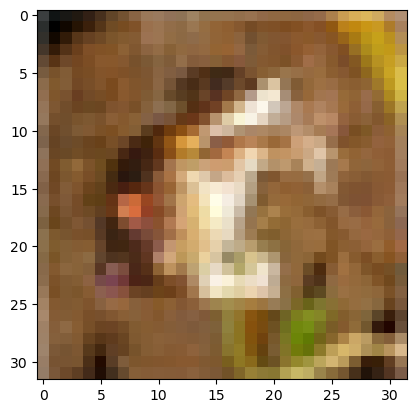

In [41]:
## [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(target)
    print('data:',data.shape)

    data1 = data.squeeze()
    print('data1:',data1.shape)

    data2=data1.transpose(0,2)
    print('imshow(data1.transpose(0,2)):', data2.shape)
    
    # plt.imshow(data)
    # plt.imshow(data1)
    plt.imshow(data2)
    break

[3] 커스텀 모델 설계 및 정의 <hr>
- 모델목적 : 이미지 분류 모델
- 학습방법 : 지도학습 > 분류 > 다중분류 (10개)
- 클래스이름 : ImageMCF
- 클래스구조 : 특징추출부분 => CNN + 학습부분 => FC
- 부모클래스 : nn.Module

In [61]:
class ImageMCF(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        # 특징 추출 층
        self.in_layer=nn.Conv2d(3, 10, 3)
        # self.in_layer=nn.Conv2d(10, 50, 3)
        # self.in_layer=nn.Conv2d(50, 10, 3)
        self.p_layer=nn.MaxPool2d(2, stride=2)


        # 학습 관련 층
        self.hd_layer=nn.Linear(10*15*15, 50)
        self.out_layer=nn.Linear(50, 10)

    # 전방향/순방향 학습 메서드
    def forward(self, x):
        # 이미지 특징 맵 추출
        output=self.in_layer(x)
        print(f'[output1]: {output.shape}')

        output=F.relu(output)
        print(f'[output2]: {output.shape}')

        output=self.p_layer(output)
        print(f'[output3]: {output.shape}')

        # 4D -> 2D (샘플수, 피쳐수)
        output=output.view(output.shape[0], -1)
        print(f'[output4]: {output.shape}')

        output=F.relu(self.hd_layer(output))
        print(f'[output5]: {output.shape}')

        output=self.out_layer(output)
        print(f'[output6]: {output.shape}')

        return output

In [62]:
### [테스트] 모델 인스턴스 생성
m=ImageMCF()

In [63]:
from torchinfo import summary
summary(m)

Layer (type:depth-idx)                   Param #
ImageMCF                                 --
├─Conv2d: 1-1                            280
├─MaxPool2d: 1-2                         --
├─Linear: 1-3                            112,550
├─Linear: 1-4                            510
Total params: 113,340
Trainable params: 113,340
Non-trainable params: 0

In [64]:
## [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(f'[target]: => {target}')
    print(data.shape)
    
    # 학습
    pre=m(data)
    print(f'pre =>{pre.argmax(dim=1)}')
    break

[target]: => tensor([6])
torch.Size([1, 3, 32, 32])
[output1]: torch.Size([1, 10, 30, 30])
[output2]: torch.Size([1, 10, 30, 30])
[output3]: torch.Size([1, 10, 15, 15])
[output4]: torch.Size([1, 2250])
[output5]: torch.Size([1, 50])
[output6]: torch.Size([1, 10])
pre =>tensor([1])


In [53]:
# 모델 파라미터 확인
for name, param in m.named_parameters():
    print(f'>>[{name}]-----------\n{param.shape}')

>>[in_layer.weight]-----------
torch.Size([10, 3, 3, 3])
>>[in_layer.bias]-----------
torch.Size([10])
>>[hd_layer.weight]-----------
torch.Size([50, 2250])
>>[hd_layer.bias]-----------
torch.Size([50])
>>[out_layer.weight]-----------
torch.Size([10, 50])
>>[out_layer.bias]-----------
torch.Size([10])


In [96]:
class ImageMCF2(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        # 특징 추출 층
        self.cnn_layer=nn.Sequential(
            nn.Conv2d(3, 10, 3),
            nn.ReLU(),
            # nn.Conv2d(10, 10, 3),
            # nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.cnn_layer2=nn.Sequential(
            nn.Conv2d(10, 30, 3),
            nn.ReLU(),
            # nn.Conv2d(30, 10, 3),
            # nn.ReLU(),
            # nn.Conv2d(10, 30, 3),
            # nn.ReLU(),
            nn.AvgPool2d(2, stride=2)
        )

        # 학습 관련 층
        self.hd_layer=nn.Linear(30*6*6, 50)
        self.out_layer=nn.Linear(50, 10)

    # 전방향/순방향 학습 메서드
    def forward(self, x):
        # 이미지 특징 맵 추출
        output=self.cnn_layer(x)
        print(f'[cnn_layer output]: {output.shape}')

        output=self.cnn_layer2(output)
        print(f'[cnn_layer2 output]: {output.shape}')

        # 4D -> 2D (샘플수, 피쳐수)
        output=output.view(output.shape[0], -1)
        print(f'[view output]: {output.shape}')

        output=F.relu(self.hd_layer(output))
        print(f'[hd_layer output]: {output.shape}')

        output=self.out_layer(output)
        print(f'[out_layer output]: {output.shape}')

        return output

In [97]:
### [테스트] 모델2 인스턴스 생성
m2=ImageMCF2()

In [98]:
summary(m2)

Layer (type:depth-idx)                   Param #
ImageMCF2                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,730
│    └─ReLU: 2-5                         --
│    └─AvgPool2d: 2-6                    --
├─Linear: 1-3                            54,050
├─Linear: 1-4                            510
Total params: 57,570
Trainable params: 57,570
Non-trainable params: 0

In [99]:
## [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(f'[target]: => {target}')
    print(data.shape)

    # 학습
    pre=m2(data)
    print(f'pre =>{pre.argmax(dim=1)}')
    break

[target]: => tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer output]: torch.Size([1, 10, 15, 15])
[cnn_layer2 output]: torch.Size([1, 30, 6, 6])
[view output]: torch.Size([1, 1080])
[hd_layer output]: torch.Size([1, 50])
[out_layer output]: torch.Size([1, 10])
pre =>tensor([1])


In [100]:
# 모델 파라미터 확인
for name, param in m2.named_parameters():
    print(f'>>[{name}]-----------\n{param.shape}')

>>[cnn_layer.0.weight]-----------
torch.Size([10, 3, 3, 3])
>>[cnn_layer.0.bias]-----------
torch.Size([10])
>>[cnn_layer2.0.weight]-----------
torch.Size([30, 10, 3, 3])
>>[cnn_layer2.0.bias]-----------
torch.Size([30])
>>[hd_layer.weight]-----------
torch.Size([50, 1080])
>>[hd_layer.bias]-----------
torch.Size([50])
>>[out_layer.weight]-----------
torch.Size([10, 50])
>>[out_layer.bias]-----------
torch.Size([10])


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))